# Data exploration Analysis 

The dataset we will be analysing is photo-based. Therefore the number of numerical analysis we can perform is limited.

DATA EXPLORATION
- Distribución de clases
- Distribucion de caracteristicas
	- Hombre/ Mujer -> Todo -> Manual
	- Tos
	- Inhalador
	- Agua
	- Teléfono
- Estadisticas sobre el color de cada clase

PERFORMANCE ANALYSIS
- Ver si podemos hacer algo con los logs
- (Ver outliers -> fotos inhalador, etc.) y ver las imágenes en cuestión

MODEL CALIBRATION
- For each class (o solo 1)



In [11]:
import sys
sys.path.append("../src")  # allow imports from src/

from data_loader import SmokerDataModule
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from collections import Counter
import pandas as pd
from PIL import Image


## Class distribution

In [12]:
dm = SmokerDataModule(data_dir="../data", batch_size=32, num_workers=4)
dm.setup()

train_dataset = dm.train_dataset
val_dataset = dm.val_dataset
test_dataset = dm.test_dataset
class_names = train_dataset.classes

print(f"Class names are {class_names}")

Class names are ['no_smoking', 'smoking']


In [13]:
def get_class_distribution(dataset):
    labels = [sample[1] for sample in dataset.samples]
    return Counter(labels)

def counts_to_df(counts, split, class_names):
    return pd.DataFrame({
        "class": [class_names[i] for i in counts.keys()],
        "count": list(counts.values()),
        "split": split
    })

train_counts = get_class_distribution(train_dataset)
val_counts = get_class_distribution(val_dataset)
test_counts = get_class_distribution(test_dataset)

df = pd.concat([
    counts_to_df(train_counts, "Train", class_names),
    counts_to_df(val_counts, "Validation", class_names),
    counts_to_df(test_counts, "Test", class_names)
])

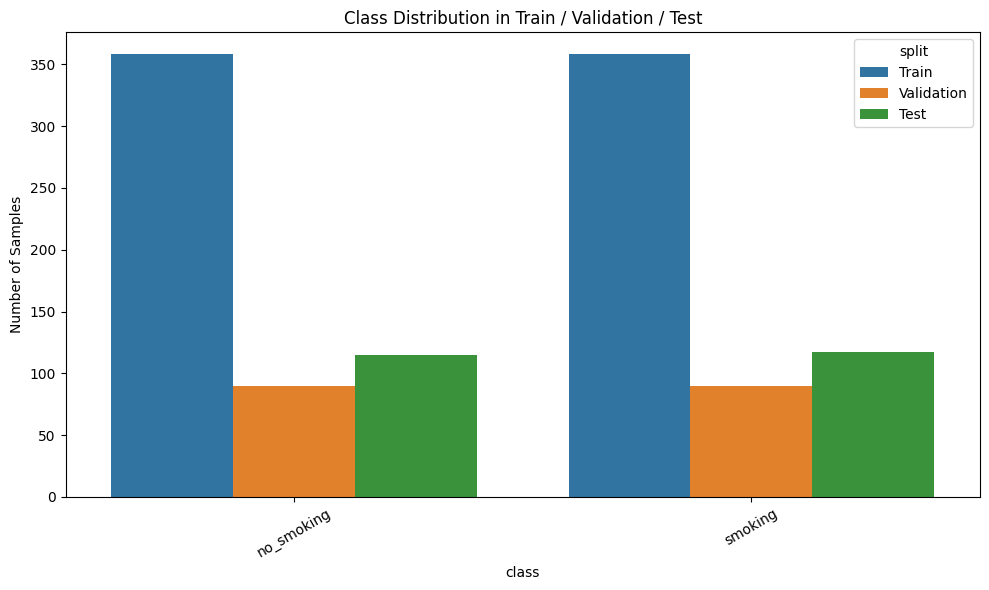

In [14]:
os.makedirs("../reports/figures", exist_ok=True) # Make sure directory exists

plt.figure(figsize=(10,6))
sns.barplot(data=df, x="class", y="count", hue="split")
plt.title("Class Distribution in Train / Validation / Test")
plt.ylabel("Number of Samples")
plt.xticks(rotation=30)
plt.tight_layout()

# Save the figure
plt.savefig("../reports/figures/class_distribution.png", dpi=300)
plt.show()

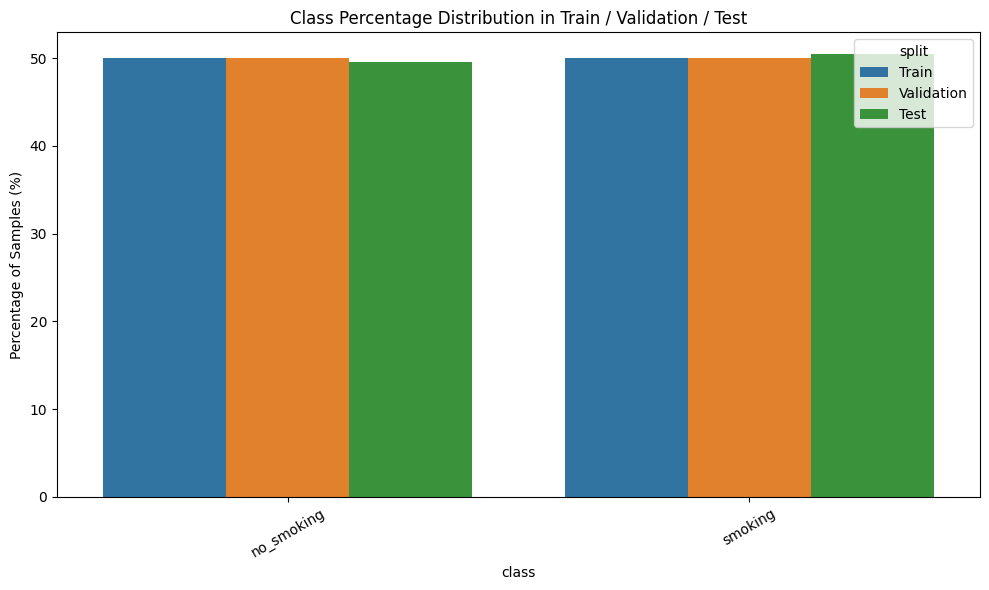

In [15]:
df_pct = df.copy()
df_pct["percent"] = df_pct.groupby("split")["count"].transform(lambda x: 100 * x / x.sum())

plt.figure(figsize=(10,6))
sns.barplot(data=df_pct, x="class", y="percent", hue="split")
plt.title("Class Percentage Distribution in Train / Validation / Test")
plt.ylabel("Percentage of Samples (%)")
plt.xticks(rotation=30)
plt.tight_layout()

# Save the figure
plt.savefig("../reports/figures/class_distribution_percentage.png", dpi=300)
plt.show()


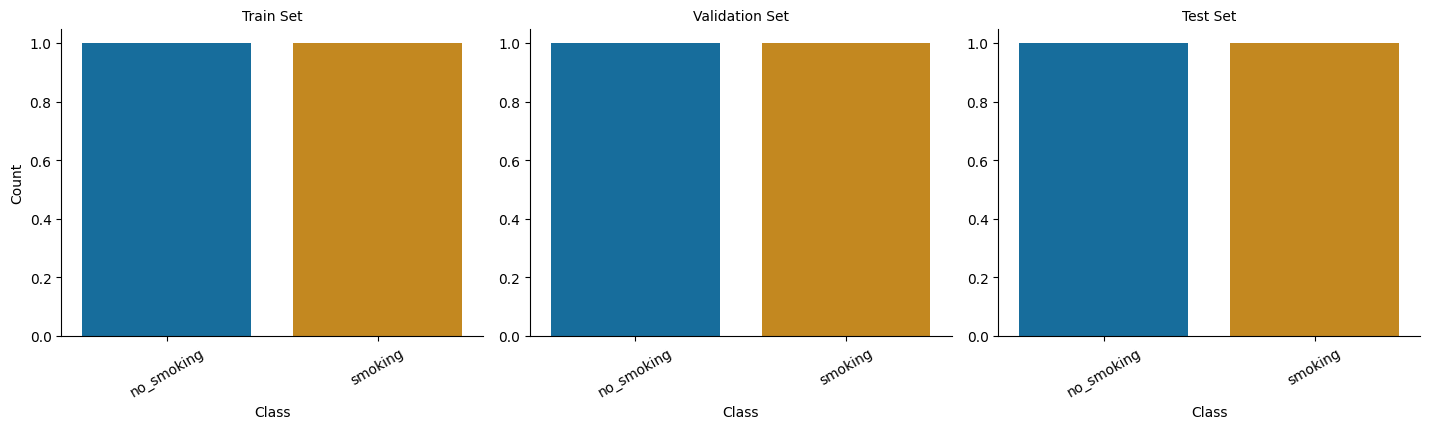

In [16]:
g = sns.catplot(
    data=df,
    x="class",
    col="split",
    kind="count",          # use 'count' so you don't need a 'count' column
    hue="class",           # different color for each class
    palette="colorblind",  # colorblind-friendly palette
    col_wrap=3,            # 3 plots in a row
    sharey=False,          # each dataset has its own y-scale
    height=4,
    aspect=1.2
)

g.set_titles("{col_name} Set")
g.set_axis_labels("Class", "Count")
for ax in g.axes:
    for label in ax.get_xticklabels():
        label.set_rotation(30)

plt.savefig("../reports/figures/class_distribution_facets.png", dpi=300)
plt.show()


## Characteristics distribution

In [17]:
# Load CSVs
categories = pd.read_csv("../data/categories.csv")   # name, category
genres = pd.read_csv("../data/genres.csv")           # filename, classification

# Rename 'filename' → 'name' so both match
genres = genres.rename(columns={"filename": "name"})

# Merge on 'name'
df_classification = pd.merge(categories, genres, on="name", how="inner")

# Keep only required columns
df_classification = df_classification[["name", "genre", "category"]]

# Rename for consistency
df_classification = df_classification.rename(columns={
    "classification": "genre",
    "category": "class"
})

df_classification.head()

,name,genre,class
0,notsmoking_0001.jpg,man,random
1,notsmoking_0002.jpg,man,random
2,notsmoking_0003.jpg,woman,random
3,notsmoking_0004.jpg,woman,random
4,notsmoking_0005.jpg,woman,random


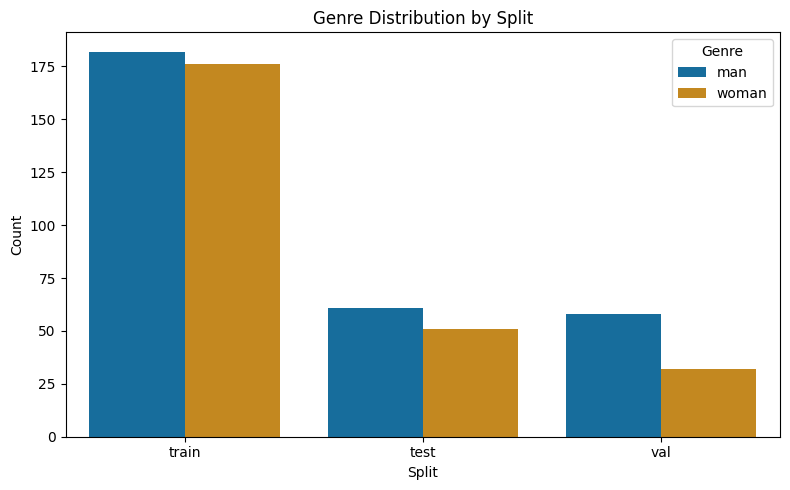

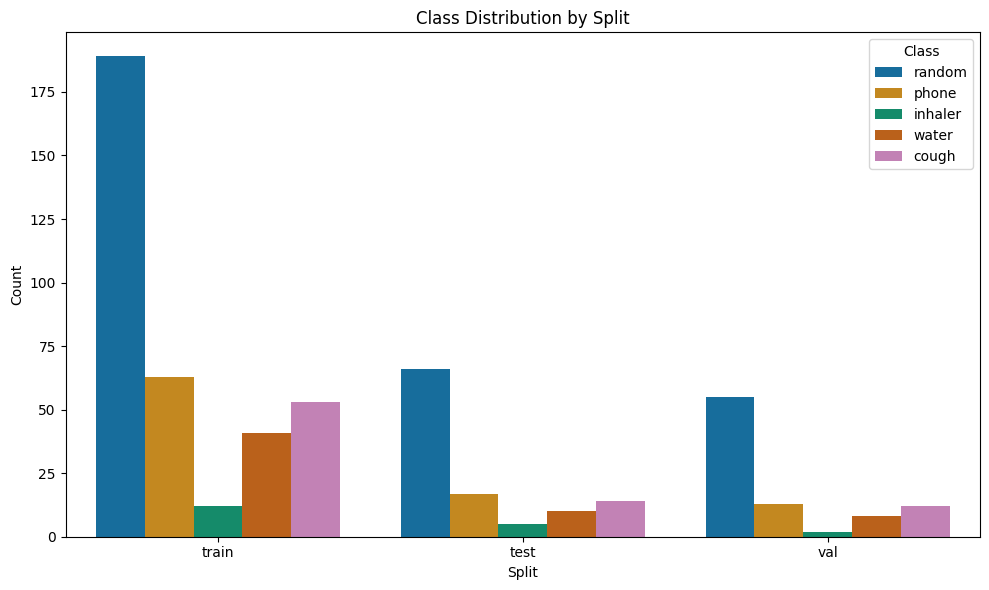

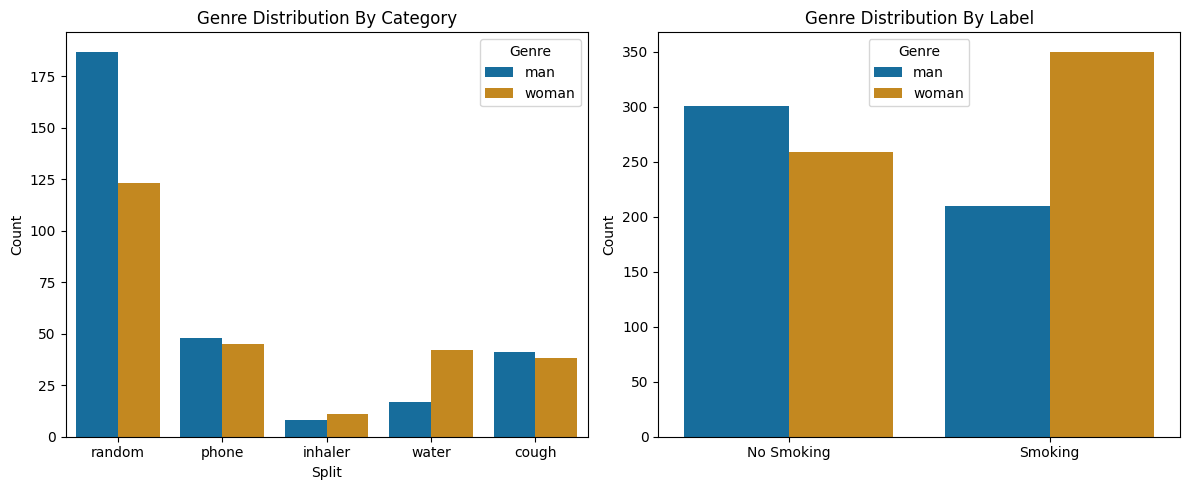

In [26]:
# ---- Get file splits from your DataModule ----
dm = SmokerDataModule(data_dir="../data", batch_size=32, num_workers=4)
dm.setup()

def dataset_to_df(dataset, split_name):
    samples = []
    for path, _ in dataset.samples:
        fname = os.path.basename(path)
        samples.append({"name": fname, "split": split_name})
    return pd.DataFrame(samples)

df_train = dataset_to_df(dm.train_dataset, "train")
df_val   = dataset_to_df(dm.val_dataset, "val")
df_test  = dataset_to_df(dm.test_dataset, "test")

df_splits = pd.concat([df_train, df_val, df_test], ignore_index=True)

# ---- Merge splits with metadata ----
df = pd.merge(df_classification, df_splits, on="name", how="inner")


# ---- Plot genre distribution ----
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="split", hue="genre", palette="colorblind")
plt.title("Genre Distribution by Split")
plt.ylabel("Count")
plt.xlabel("Split")
plt.legend(title="Genre")
plt.tight_layout()
plt.show()

# ---- Plot class distribution ----
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="split", hue="class", palette="colorblind")
plt.title("Class Distribution by Split")
plt.ylabel("Count")
plt.xlabel("Split")
plt.legend(title="Class")
plt.tight_layout()
plt.show()

# ---- Genre Distribution By Category ----
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x="class", hue="genre", palette="colorblind")
plt.title("Genre Distribution By Category")
plt.ylabel("Count")
plt.xlabel("Split")
plt.legend(title="Genre")
plt.tight_layout()

# ---- Genre Distribution By Label ----
df_classes = pd.read_csv("../data/class.csv")
df_classes["label"] = df_classes["label"].replace({0: "No Smoking", 1:"Smoking"})
df_genre = pd.read_csv("../data/genres.csv")
df_cls_genre = pd.merge(df_genre, df_classes, on="name", how="inner")

plt.subplot(1, 2, 2)
sns.countplot(data=df_cls_genre, x="label", hue="genre", palette="colorblind")
plt.title("Genre Distribution By Label")
plt.ylabel("Count")
plt.xlabel("")
plt.legend(title="Genre")
plt.tight_layout()
plt.savefig("../reports/figures/genre_distribution.png", dpi=300)
plt.show()

## Mean colours per class

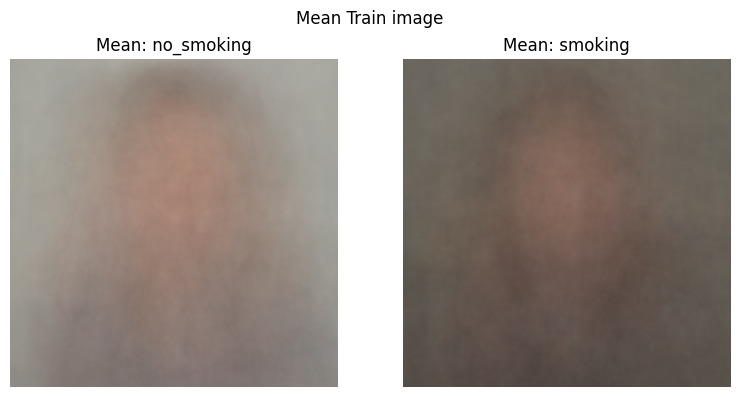

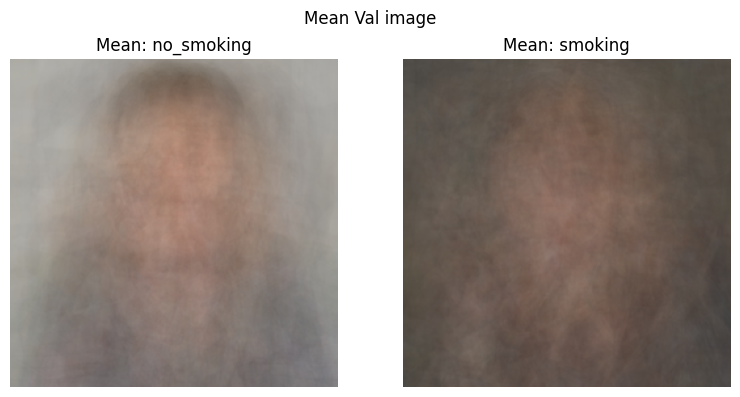

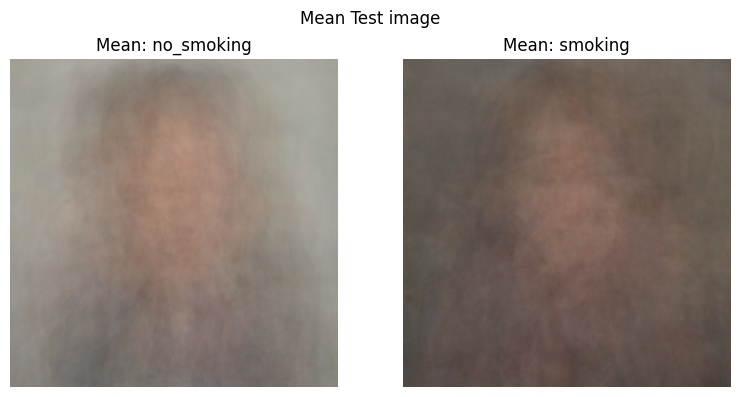

In [9]:
def compute_mean_images_from_dataset(dataset, class_names, img_size=(250, 250)):
    imgs_by_class = {cls: [] for cls in class_names}

    for path, class_idx in dataset.samples:
        try:
            img = Image.open(path).convert("RGB")
            img = img.resize(img_size)
            img = np.array(img, dtype=np.float32) / 255.0
            imgs_by_class[class_names[class_idx]].append(img)
        except Exception as e:
            print(f"Skipping {path}: {e}")

    mean_images = {}
    for cls, imgs in imgs_by_class.items():
        if imgs:
            mean_images[cls] = np.mean(imgs, axis=0)
    
    return mean_images


# --- Compute using datasets ---
mean_images_train = compute_mean_images_from_dataset(train_dataset, class_names)
mean_images_val = compute_mean_images_from_dataset(val_dataset, class_names)
mean_images_test = compute_mean_images_from_dataset(test_dataset, class_names)
mean_images = {
    "Train": mean_images_train,
    "Val": mean_images_val,
    "Test": mean_images_test
}

# --- Plot ---
for name, mean_image in mean_images.items():
    n_classes = len(mean_image)
    plt.figure(figsize=(4 * n_classes, 4))
    for i, (cls, mean_img) in enumerate(mean_image.items(), 1):
        plt.subplot(1, n_classes, i)
        plt.imshow(mean_img)
        plt.title(f"Mean: {cls}")
        plt.axis("off")
    plt.suptitle(f"Mean {name} image")
    plt.tight_layout()
    plt.show()
